**Mapping closure for $f_B$ in 1D**

This notebook introduces the mapping closure developed by (Chen, H. 1989) and extended to higher dimensions by (Pope, S.B. 1991) and discusses how it can be applied to the problem of turbulent scalar mixing. In contrast to these works which consider a one-point pdf, usually in the context of homogeneous isotropic turbulence, we consider the *global pdf* describing the contents of an arbitrary control volume.


**Content**

We first import all the packages we need to run this example

In [1]:
import numpy as np
import dedalus.public as d3
import h5py
import logging
logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

**A) Scalar Mixing**

To motivate the problem, we consider the case of a passive scalar $Y(\mathbf{x},t)$ which evolves in a flow $\mathbf{U}(\mathbf{x},t)$ according to the advection-diffusion equation
\begin{equation}
\frac{\partial Y}{\partial t} + \mathbf{U} \cdot \nabla Y = \Gamma \nabla^2 Y,
\end{equation}
where $\Gamma$ is a scalar diffusvity, such that the CDF of the scalar field is given by
\begin{equation}
F(y,t) = \text{Prob} \{ Y(\mathbf{x},t) < y\},
\end{equation}
and its pdf by $f(y,t) = \partial_{y} F(Y , t)$. Below we show an example of the time evolution of $Y(\mathbf{x},t)$ and $f(y,t)$ in a 3D periodic box starting from the initial condition consisting of a sharp interface,
\begin{equation}
Y(\mathbf{x},t=0) = \tanh(10\mathbf{x}).
\end{equation}
*NOTE: This takes about 3 minutes to run.*

In [ ]:
# Parameters
Γ  = 1;  # Equivalent to Peclet number
Nx = 32;   # This can be reduced but it will increase the noise in the histogram
stop_sim_time = 1
timestep = 1e-03

# Domain
coords = d3.CartesianCoordinates('x','y','z')
dist   = d3.Distributor(coords, dtype=np.float64)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(-np.pi, np.pi), dealias=3/2)
ybasis = d3.RealFourier(coords['y'], size=Nx, bounds=(-np.pi, np.pi), dealias=3/2)
zbasis = d3.RealFourier(coords['z'], size=Nx, bounds=(-np.pi, np.pi), dealias=3/2)

# Fields
S = dist.Field(name='S', bases=(xbasis,ybasis,zbasis))
U = dist.VectorField(coords, name='U', bases=(xbasis,ybasis,zbasis))
x,y,z = dist.local_grids(xbasis,ybasis,zbasis)

A,B,C = 1,1,1;
# ABC flow
U['g'][0] = A*np.sin(z) + C*np.cos(y);
U['g'][1] = B*np.sin(x) + A*np.cos(z);
U['g'][2] = C*np.sin(y) + B*np.cos(x);

# Initial condition
S['g']    = np.tanh(10*(x + y + z))

# Problem
grad_S  = d3.grad(S)
problem = d3.IVP([S], namespace=locals())
problem.add_equation("dt(S) - Γ*div(grad_S) = -U@grad(S)") #

# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = stop_sim_time

# Flow properties
snapshots = solver.evaluator.add_file_handler('snapshots', iter=1)
snapshots.add_task(S,      layout='g',name='S',scales=3/2)
snapshots.add_task(Γ*d3.div(grad_S), layout='g',name='Lap_S',scales=3/2)

# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)

        if (solver.iteration-1) % (int(stop_sim_time/timestep) // 10) == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e'%(solver.iteration, solver.sim_time, timestep))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

Having time integrated the transport equation for the scalar concentration we have a set of snapshots $Y(\mathbf{x},t)$ at discrete time intervals $t_n$. Loading the numerical snapshots saved below we show a 2D cross section of the scalar field and its corresponding PDF.

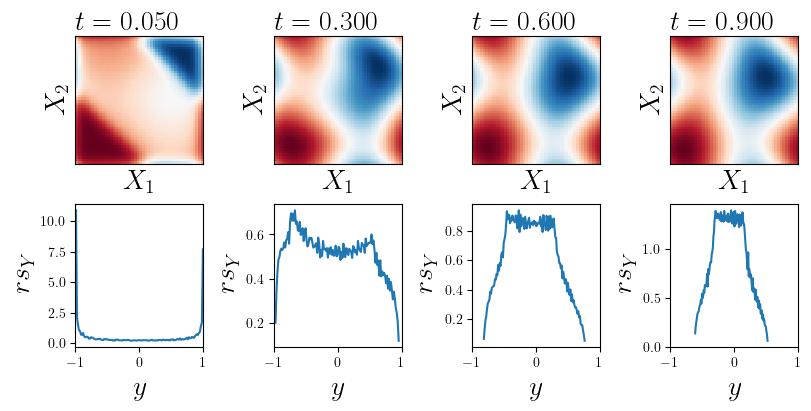

In [4]:
# Data loading
file   = h5py.File('./snapshots/snapshots_s1.h5', mode='r')
times  = file['tasks/S'].dims[0][0][:]
x_data = file['tasks/S'].dims[1][0][:]
y_data = file['tasks/S'].dims[2][0][:]
S_data = file['tasks/S'][:,...]

def PDF(S_data,t,N_bins=128):
  f,s= np.histogram(S_data[t,...].flatten(), bins=N_bins,density=True)
  s  = 0.5*(s[1:] + s[:-1]); ds = s[1] - s[0]
  #F = np.cumsum(f)*ds
  return s,f

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 4) ,layout="constrained")

for i,t in enumerate([50,300,600,900]):
  ax[0,i].pcolormesh(x_data, y_data, S_data[t,:,:,0],cmap='RdBu',norm='linear')
  ax[1,i].plot(PDF(S_data,t)[0],PDF(S_data,t)[1])
  ax[0,i].annotate(r'$t=%3.3f$'%times[t], xy=(0.0, 1.05), xycoords='axes fraction', fontsize=20)

for i in range(4):
  ax[0,i].set_aspect('equal')
  ax[0,i].set_xlabel(r'$X_1$', fontsize=20)
  ax[0,i].set_ylabel(r'$X_2$', fontsize=20)
  ax[0,i].set_yticks([])
  ax[0,i].set_xticks([])

  #ax[1,i].set_aspect(2)
  ax[1,i].set_xlabel(r'$y$', fontsize=20)
  ax[1,i].set_ylabel(r'$f_Y$', fontsize=20)
  ax[1,i].set_xlim([-1,1])


As shown above, the initial condition consisting of two scalar concentrations at $y = \pm 1$ is mixed thereby gradually transforming the pdf $f_Y$. We want to model this process directly in terms of the pdf $f_Y$.

**B) Evolution equation for the PDF**

Following [Pope et al. 1985](https://www.sciencedirect.com/science/article/abs/pii/0360128585900024) the evolution equation for these distributions is given by

\begin{equation}
\frac{\partial F}{\partial t} = -\mathbb{E}_Y[ \Gamma \nabla^2 Y ] \frac{\partial F}{\partial y},
\end{equation}

and

\begin{equation}
\frac{\partial f}{\partial t} = -\frac{\partial }{\partial y} \left( \mathbb{E}_Y[ \Gamma \nabla^2 Y ] f \right).
\end{equation}

As $f(y,t)$ contains no information about space this equation is unclosed as the conditional expectation is unknown, however we can apply the mapping closure developed by [Pope et al. 1991](https://link.springer.com/article/10.1007/BF00271466) to estimate a closure for the molecular mixing terms.

The idea behind this closure relies on Gaussian random fields. What makes these "random" fields particularly useful is:
- They are completely defined by their mean and covariance: 
\begin{equation}
    \mu = \mathbb{E}[\theta(\mathbf{z})], \quad \rho(r) = \mathbb{E}[\theta(\mathbf{z})\theta(\mathbf{z} + \mathbf{e}r)] - \mu^2,
\end{equation}
- Allow the calculate explicity the conditional expectation
\begin{equation}
lim_{r \to 0} \frac{\partial^2 \rho(r)}{\partial r^2} = \left\langle \frac{\partial \theta}{\partial z_i} \frac{\partial \theta}{\partial z_i} \right\rangle,
\end{equation}

and the fact that mutliple different field can have the same global PDF. Below we show and example of a Gaussian random field $\theta(\mathbf{z})$ with a $-5/3$ power-spectrum.


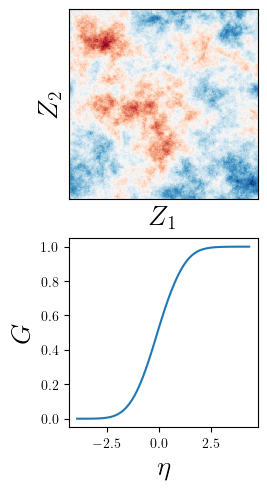

In [2]:
# Function to generate a Gaussian Random field
def gaussian_random_field(power_spectrum, shape = (128, 128), stat_real=False):
  """
  Generate a scale free Gaussian Random field Y(X) using the
  fast Fourier transform (FFT) and the power spectral density P(k)

  Y(x) = IFFT( P(k) * FFT(W(X)) )(X)

  where W(X) is a Gaussian white noise random field.

  Parameters
  ----------
  power_spectrum : (callable)
    Power spectral density P(k)
  shape : (int, int) G
    Grid size of the field generated

  Returns
  -------
  Y(X) : (array)
    Gaussian random field
  """
  if not callable(power_spectrum):
    raise Exception("`power_spectrum` should be callable")

  def statistic(shape):
    # Build a unit-distribution of complex numbers with random phase
    a = np.random.normal(loc=0, scale=1, size=shape)
    b = np.random.normal(loc=0, scale=1, size=shape)
    return a + 1j * b

  # Compute the k grid
  fftfreq = np.fft.fftfreq
  all_k = [fftfreq(s, d=1/s) for s in shape]
  kgrid = np.meshgrid(*all_k, indexing="ij")  # Reutrns kX, kY
  knorm = np.sqrt(np.sum(np.power(kgrid, 2), axis=0))  # Computes ||k|| = \sqrt{kX^2 + kY^2}

  # (1) Compute the Fourier transform of Gaussian White noise W(X)
  if stat_real:
    W = statistic(shape)
    # Compute the FFT of the field
    FW = np.fft.fftn(W)
  else:
    # Draw a random sample in Fourier space
    fourier_shape = knorm.shape
    FW = statistic(fourier_shape)

  # (2) Multiply by P(k)^{1/2}
  power_k = np.zeros_like(knorm)
  mask = knorm > 0
  power_k[mask] = np.sqrt(power_spectrum(knorm[mask]))
  FW *= power_k

  # (3) Take its IFFT
  return  np.real(np.fft.ifftn(FW))

# Create an example
n_pts = 512
power_spectrum = lambda k: k**-3
shape = (n_pts, n_pts)

Z_1 = np.linspace(-np.pi,np.pi,num=n_pts)
Z_2 = np.linspace(-np.pi,np.pi,num=n_pts)
Ys = gaussian_random_field(power_spectrum, shape) # Ys for Y surrogate

# Plot Z(z) and F_Z
fig, (ax0,ax1) = plt.subplots(nrows=2, ncols=1, layout="constrained")

# plot Ys(Z) as a field
cmap = plt.get_cmap('RdBu')
ax0.pcolormesh(Z_1, Z_2, Ys, cmap=cmap)
ax0.set_xlabel(r'$Z_1$', fontsize=20)
ax0.set_ylabel(r'$Z_2$', fontsize=20)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_box_aspect(1)

# plot its cdf by averaging over realisations
Ys = []
for i in range(64):
  Ys_i = gaussian_random_field(power_spectrum, shape)
  Ys.append(Ys_i.flatten())
Ys = np.concatenate(Ys).flatten()

sigma = np.std(Ys)
mean = np.mean(Ys)

Ys = (Ys - mean)/sigma

f,s= np.histogram(Ys, bins=64, density=True)
s  = 0.5*(s[1:] + s[:-1]); ds = s[1] - s[0]
F = np.cumsum(f)*ds
ax1.plot(s, F)
ax1.set_xlabel(r'$\eta$', fontsize=20)
ax1.set_ylabel(r'$G$', fontsize=20)
ax1.set_box_aspect(1)

plt.show()

**C) Mapping Closure**

Based on the properties of the Gaussian random field the idea is therefore to find a mapping 
\begin{equation}
\tilde{Y}(\mathbf{x},t) = \mathscr{Y}(\theta(\mathbf{x} J(t)),t),
\end{equation}
such that we can express the CDF $F$ in terms of the cumulative Gaussian $G$ 
\begin{equation}
F(\mathscr{Y}(\eta,t),t) = G(\eta).
\end{equation}

Differentiating the last equation we obtain
\begin{equation}
\frac{ \partial F}{\partial t} = -\frac{ \partial \mathscr{Y}}{\partial t} \frac{ \partial F}{\partial y}.
\end{equation}
which can then be expressed as
\begin{equation}
\frac{\partial \mathscr{Y}}{\partial t} = \mathbb{E}_Y[ \Gamma \nabla^2 Y ] = \Gamma \frac{J^2(t)}{\lambda_{\theta}^2} \left( -\eta \mathscr{Y}'(\eta,t) + \mathscr{Y}''(\eta,t) \right).
\end{equation}

**D) Application to scalar mixing**

As a test of this method we consider the mixing of the initial condition $Y(\mathbf{x},t=0)$ consisting of blobs of fluid at $y = \pm 1$ such that
\begin{equation}
f(y,t=0) = 1/2[ \delta(y-1)+ \delta(y+1)],
\end{equation}
and
\begin{equation}
\mathscr{Y}(\eta,t=0) = 2H(\eta,0) - 1.
\end{equation}

Below we numerically solve the mapping's parabolic evolution equation derived above subject to the Neumann boundary conditions $\partial_{\eta} \mathscr{Y} = 0$ at $\pm \infty$ or numerically the limits of the finite domain. Solving this equation we obtain a numerical approximation $\mathscr{Y}(\eta_i,t_n)$ on the sample space $\eta_n$ and time $t_i$ grids.

In [3]:
from derivatives import *
from scipy.integrate import trapezoid as trapz

def Map_Solver(X_0, η, T,Δt, J = lambda t: 1):

  N_η = len(η)
  N_T = len(T)
  D_η = grad(η)
  L_η = laplacian(η, bcs='Neumann')
  L   = -np.diag(η)@D_η + L_η
  I   = np.eye(L.shape[0])

  A = lambda t: I/Δt - J(t)*L/2
  B = lambda t: I/Δt + J(t)*L/2

  X      = np.zeros((N_T,N_η))
  X[0,:] = X_0
  for n,t in enumerate(T[:-1]):
    X[n+1,:] = np.linalg.solve(A(t),B(t)@X[n,:])
    # plt.plot(η,X[n,:])
    # plt.show()

  return X;

# Domain
N_η  = 256
N_T  = 10**3
η,dη = np.linspace(-5,5,N_η,retstep=True);
T,Δt = np.linspace( 0,1,N_T,retstep=True);

# Initial condition
X_0 = 2*np.heaviside(η,0) - 1

# Solve
X   = Map_Solver(X_0, η, T,Δt, J = lambda t: 1)

Having solved for $\mathscr{Y}(\eta_n,t_i)$ we then use this to recover the CDF by differentiating
\begin{equation}
\partial_{\eta} \left( F(\mathscr{Y}(\eta,t),t) - G(\eta) \right) = f(\mathscr{Y}(\eta,t),t) \frac{\partial \mathscr{Y}}{\partial \eta} - g(\eta) = 0,
\end{equation}
and rearranging in terms of $f$ to obtain
\begin{equation}
f(\mathscr{Y}(\eta,t),t)  = g(\eta)/ \frac{\partial \mathscr{Y}}{\partial \eta}.
\end{equation}
Below we plot the time evolution of $f(\mathscr{Y}(\eta,t),t)$ recovered in this manner as well as integrating it over sample space to check it defines a pdf.

int f dx =  0.9999944570656392
int f dx =  0.9999992886204595
int f dx =  0.99999928872954
int f dx =  0.9999992889583729


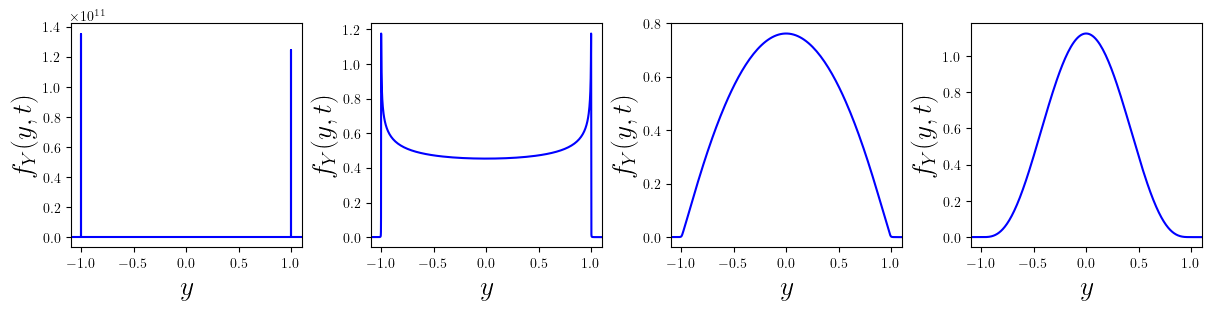

In [4]:
# Create the map from X to f
D_η = grad(η)
dXdη = ( D_η@(X.T) ).T
g    = lambda η: (1./np.sqrt(2*np.pi) )*np.exp(-.5*(η**2))
f    = lambda n: g(η[1:-1])/dXdη[n,1:-1]

# Plot
fig, ax = plt.subplots(ncols=4, figsize = (12, 3), layout="constrained")

for i,n in enumerate([50,300,600,900]):
    ax[i].plot(X[n,1:-1],f(n),'b-')
    ax[i].set_ylabel(r'$f_Y(y,t)$',fontsize=20)

    # check integral constraint int f dx = 1
    print('int f dx = ',trapz(f(n),X[n,1:-1]) )

for axs in ax:
    axs.set_xlabel(r'$y$',fontsize=20)
    axs.set_xlim([-1.1, 1.1])

plt.show()

Comparing this figure with the simulation output we see that the essential physics of the mixing is captured, whereby as the scalar field homogenises, the bimodal distribution tends towards a Dirac measure. To ensure that the mass of the distribution is conserved we find that it is important that the domain of $\eta$ is sufficiently large such that the boundary conditions on the mapping are not felt.

**E) Forced scalar mixing**

For inhomogeneous flows which have a forcing term the governing equation for the density becomes

\begin{equation}
\frac{\partial f}{\partial t} = -\frac{\partial }{\partial y} ( \boldsymbol{D}^{(1)} f ) - \frac{\partial^2 }{\partial y^2} \left( \mathbb{E}_Y[ \Gamma |\nabla Y|^2 ] f \right).
\end{equation}

Applying the mapping closure to this equation yields 

\begin{equation}
    \frac{\partial \mathscr{Y}}{\partial t} = \boldsymbol{D}^{(1)} + \Gamma \frac{J^2(t)}{\lambda_{\theta}^2} \left(-\eta \frac{\partial \mathscr{Y}}{\partial \eta}+\frac{\partial^2\mathscr{Y}}{\partial \eta^2}\right).
\end{equation}

To see if this equation can reproduce the multi-modal density characteristic of stratifications we generate a multi-modal PDF and then solve for the forcing.

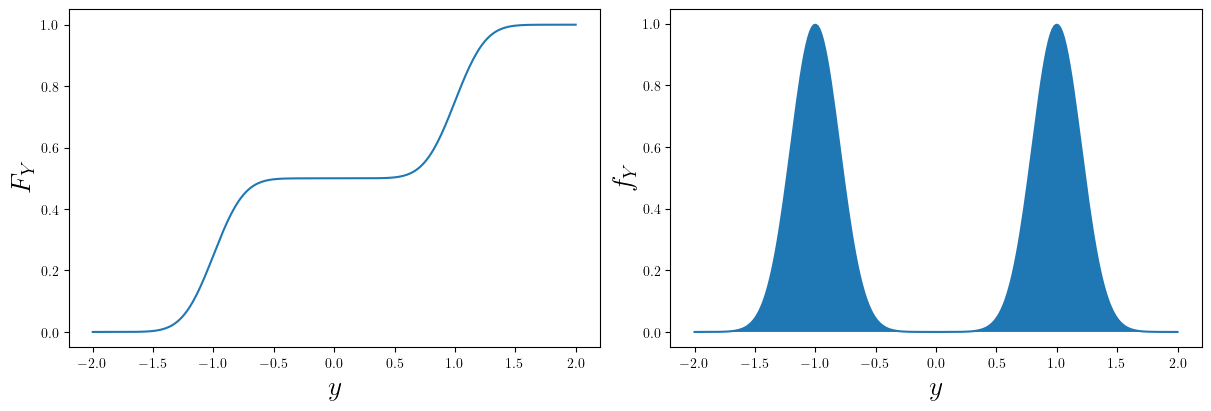

In [23]:
# Numerical grid
y, dy = np.linspace(-2,2,N_η,retstep=True);

# Location of 'interface(s)'
loc = [-1, 1]  # Mean/height of the layer
std = [0.2, 0.2]  # Standard deviation of the layer
amp = [1, 1]  # Changes the maximum and minimum buoyancy of the layer

# Enforce normalisation
SUM = np.sum(amp)
amp = [i/SUM for i in amp]

from forcing import make_F, make_f
F_Y = make_F(loc, std, amp)
f_Y = make_f(loc, std, amp)

fig, (ax1,ax2) = plt.subplots(ncols=2, layout='constrained', figsize=(12,4))
ax1.plot(y, F_Y(y))
ax1.set_ylabel(r'$F_Y$', fontsize=20)
ax1.set_xlabel(r'$y$', fontsize=20)

ax2.plot(y, f_Y(y))
ax2.fill_between(y, f_Y(y))
ax2.set_ylabel(r'$f_Y$', fontsize=20)
ax2.set_xlabel(r'$y$', fontsize=20)

plt.show()

We then solve for the forcing, by first solving the equation

\begin{equation}
    F(\mathscr{Y}(\eta)) = G(\eta),
\end{equation}

using a root finding algorithm and then evaluating the forcing from

\begin{equation}
\boldsymbol{D}^{(1)} = - \Gamma \frac{J^2(t)}{\lambda_{\theta}^2} \left(-\eta \frac{\partial \mathscr{Y}}{\partial \eta}+\frac{\partial^2\mathscr{Y}}{\partial \eta^2}\right).
\end{equation}

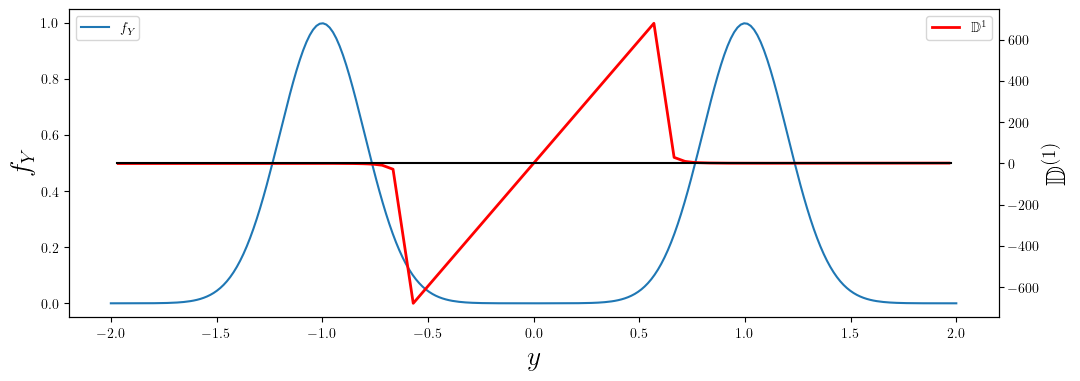

In [24]:
from scipy.optimize import root_scalar
from scipy.special import erf

G = lambda η : (1+erf(η/np.sqrt(2)))/2

# 3) Generate the map Y_map required to produce this pdf
def make_map(F, G, η):
    """Calculate the inverse of F"""
    Y_map = []
    for η_i in η:
        func = lambda x: F(x) - G(η_i)
        sol = root_scalar(func, bracket=[-10*max(η), 10*max(η)], method='brentq')
        Y_map.append(sol.root)
    return np.asarray(Y_map)

Y_map = make_map(F_Y, G, η)

# Generate the forcing
D_η = grad(η)
L_η = laplacian(η, bcs='Neumann')
L  = -np.diag(η)@D_η + L_η 
D1 = -L @ Y_map

# Check the mapped pdf matches
dY_map_dη = D_η @ Y_map
f_map = g(η)/dY_map_dη

fig = plt.figure(figsize=(12, 4))
ax1 = plt.gca()
ax2 = ax1.twinx()

#ax1.plot(Y_map, f_map, label=r'Mapped $f_Y$')
ax1.plot(y, f_Y(y), label=r'$f_Y$')
#ax1.fill_between(Y_map, f_map)
#ax1.set_xlim([0, 1])
#ax1.set_ylim([0, 1.1*np.max(f_map)])
ax1.set_xlabel(r'$y$', fontsize=20)
ax1.set_ylabel(r'$f_Y$', fontsize=20)
ax1.legend(loc=2)

ax2.plot(Y_map[1:-1], D1[1:-1], '-r', linewidth=2, label=r'$\mathbb{D}^1$')
ax2.plot(Y_map, 0*Y_map, '-k')
#ax2.set_xlim([0, 1])
ax2.set_ylabel(r'$\mathbb{D}^{(1)}$', fontsize=20)
ax2.legend()

plt.show()

As the number of grid points $N \to \infty$ the forcing seems to be possible to approximate at y = 0.5 for the current parameters however there is a singularity. Of which type I do not know, but the forcing is approximately $\mathbb{D}^{(1)} \sim 1/(y - 0.5)$  either multiplied by a very small constant or the denominator is taken to a higher odd power. 

We then time-step the forced system, importantly the system can reproduce the bimodal PDF corresponding to the forcing applied.

In [ ]:
def time_step(X_0, η, D1, L, Nt, T_end, J=lambda t: 1):

    Nη = L.shape[0]
    II = np.eye(Nη)
    T, Δt = np.linspace(0, T_end, Nt, retstep=True)

    LHS = lambda t: II/Δt - J(t)*L/2
    RHS = lambda t: II/Δt + J(t)*L/2

    X = np.zeros((Nt, Nη))
    X[0, :] = X_0
    for n, t in enumerate(T[:-1]):
        X[n+1, :] = np.linalg.solve(LHS(t), RHS(t)@X[n, :] + D1)

        # 0) Plot the system out
        if n%(len(T)//10) == 0:
            D_η = grad(η)
            dY_map_dη = D_η @ X[n, :]
            f_map = g(η)/dY_map_dη
            print('t = %3.3f , int f db = %3.3f \n' %(t,trapz(y=f_map,x=X[n,:]) ))
            fig = plt.figure()
            plt.ylabel('$f_Y(y)$')
            plt.xlabel('$y$')
            plt.plot(X[n, :], f_map)
            plt.show()

    return X, T

# Start from an arbitrary initial condition corresponding to a Gaussian
X_0 = np.linspace(-5, 5, len(η))
Nt = 2*(10**3)
T_end = 100
X, t = time_step(X_0, η, D1, L, Nt, T_end, J=lambda t: 1)

Finally we show that we can repeat this by adding additional modes to the PDF and observe that it still reproduces the correct PDF. Below we generate a three layered stratification by changing the following parameters

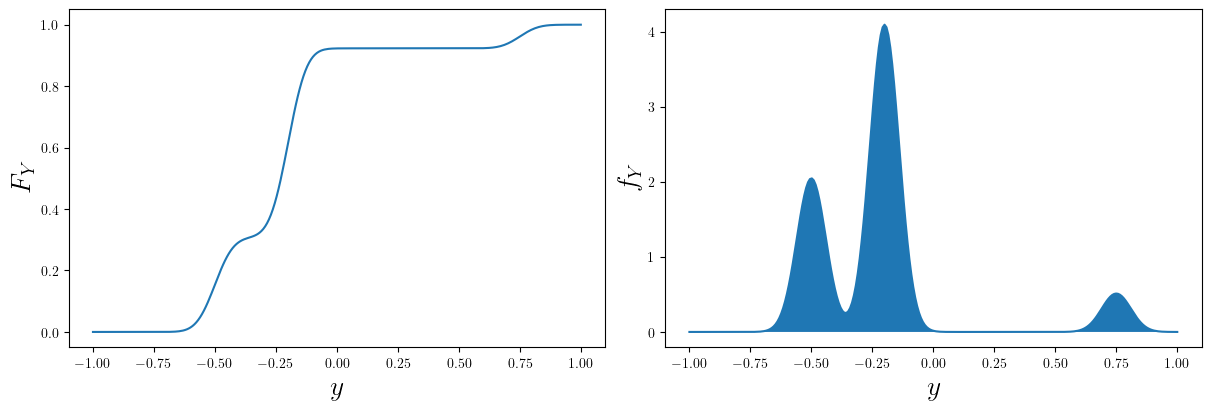

In [44]:
# Numerical grid
y, dy = np.linspace(-1,1,N_η,retstep=True);

loc = [-0.2, -0.5, 0.75]  # Mean/height of the layer
std = [0.06, 0.06, 0.06]  # Standard deviation of the layer
amp = [4, 2, 0.5]  # Changes the maximum and minimum buoyancy of the layer

# Enforce normalisation
SUM = np.sum(amp)
amp = [i/SUM for i in amp]

from forcing import make_F, make_f
F_Y = make_F(loc, std, amp)
f_Y = make_f(loc, std, amp)

fig, (ax1,ax2) = plt.subplots(ncols=2, layout='constrained', figsize=(12,4))
ax1.plot(y, F_Y(y))
ax1.set_ylabel(r'$F_Y$', fontsize=20)
ax1.set_xlabel(r'$y$', fontsize=20)

ax2.plot(y, f_Y(y))
ax2.fill_between(y, f_Y(y))
ax2.set_ylabel(r'$f_Y$', fontsize=20)
ax2.set_xlabel(r'$y$', fontsize=20)

plt.show()

As before we then construct the forcing by obtaining the mapping corresponding to the CDF 

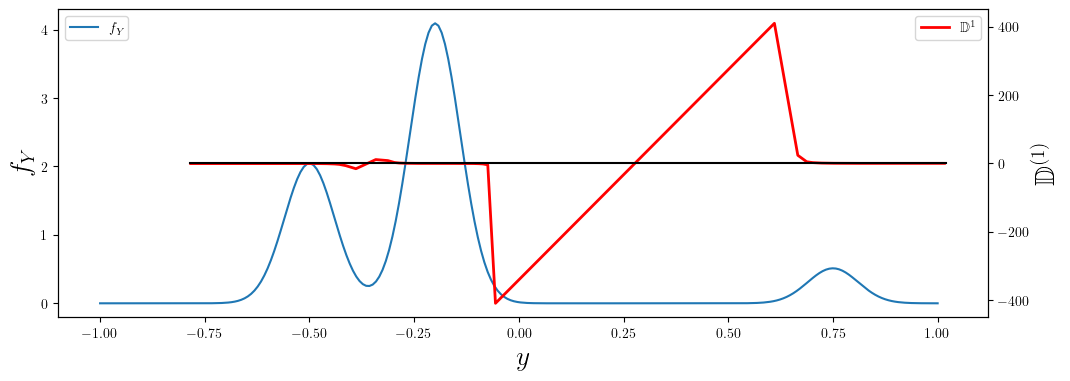

In [45]:

Y_map = make_map(F_Y, G, η)

# Generate the forcing
D_η = grad(η)
L_η = laplacian(η, bcs='Neumann')
L  = -np.diag(η)@D_η + L_η 
D1 = -L @ Y_map

# Check the mapped pdf matches
dY_map_dη = D_η @ Y_map
f_map = g(η)/dY_map_dη

fig = plt.figure(figsize=(12, 4))
ax1 = plt.gca()
ax2 = ax1.twinx()

#ax1.plot(Y_map, f_map, label=r'Mapped $f_Y$')
ax1.plot(y, f_Y(y), label=r'$f_Y$')
#ax1.fill_between(Y_map, f_map)
#ax1.set_xlim([0, 1])
#ax1.set_ylim([0, 1.1*np.max(f_map)])
ax1.set_xlabel(r'$y$', fontsize=20)
ax1.set_ylabel(r'$f_Y$', fontsize=20)
ax1.legend(loc=2)

ax2.plot(Y_map[1:-1], D1[1:-1], '-r', linewidth=2, label=r'$\mathbb{D}^1$')
ax2.plot(Y_map, 0*Y_map, '-k')
#ax2.set_xlim([0, 1])
ax2.set_ylabel(r'$\mathbb{D}^{(1)}$', fontsize=20)
ax2.legend()

plt.show()

And then lastly we run the model again

t = 0.000 , int f db = 1.000 



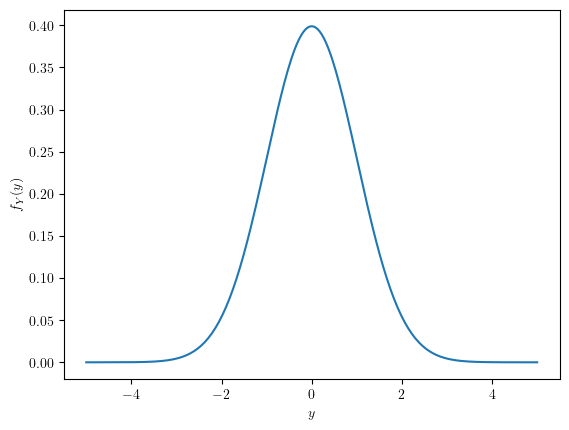

t = 1.001 , int f db = 1.000 



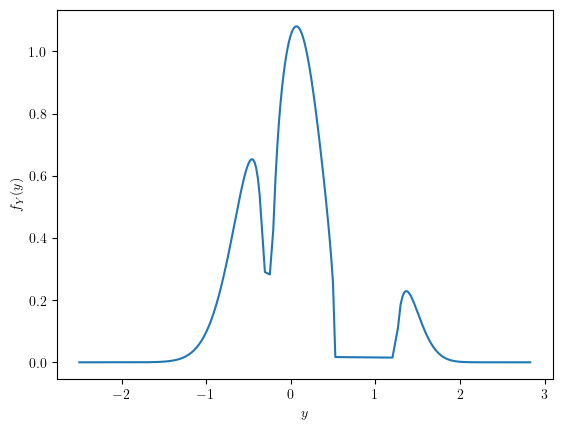

t = 2.001 , int f db = 1.000 



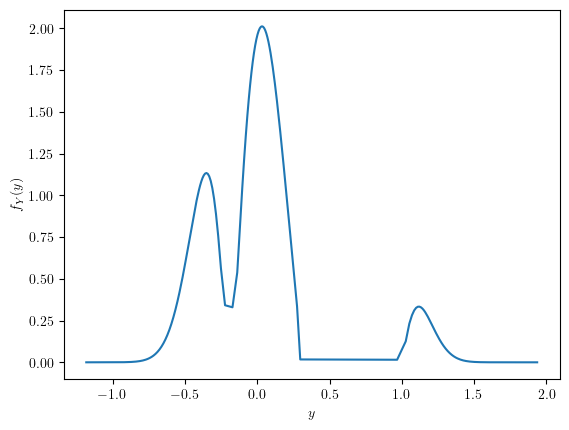

t = 3.002 , int f db = 1.000 



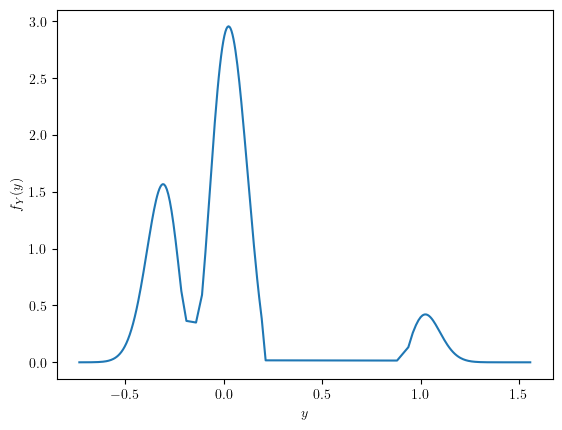

t = 4.002 , int f db = 1.000 



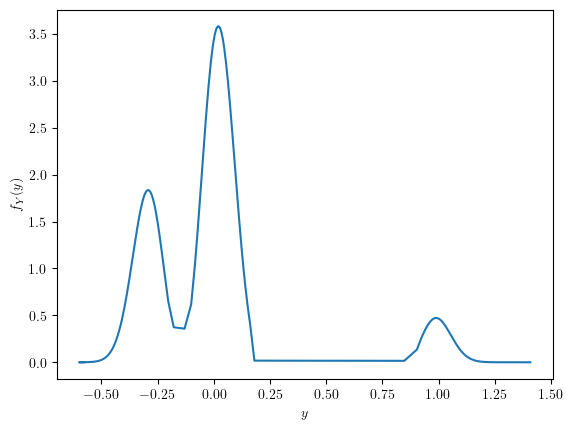

t = 5.003 , int f db = 1.000 



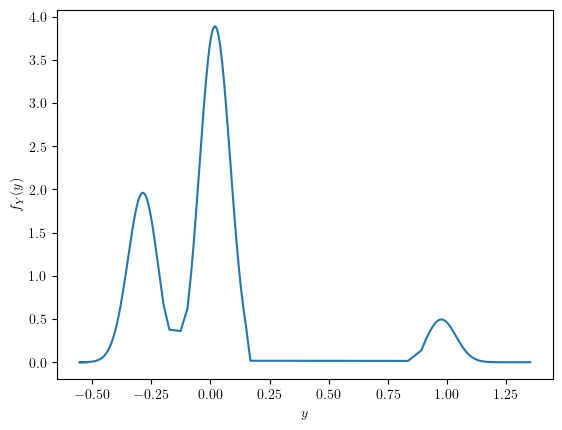

t = 6.003 , int f db = 1.000 



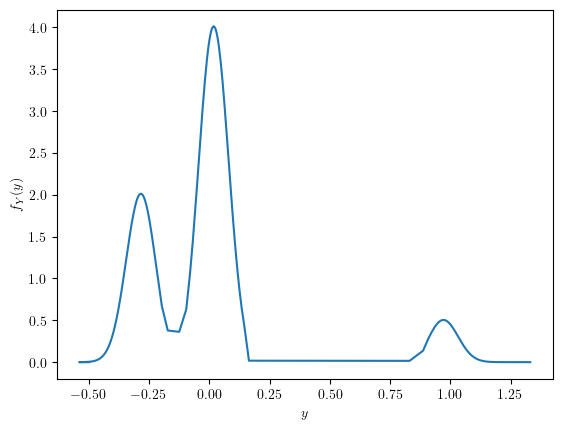

t = 7.004 , int f db = 1.000 



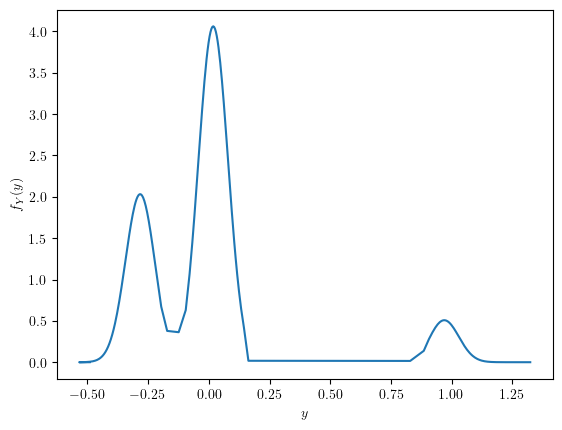

t = 8.004 , int f db = 1.000 



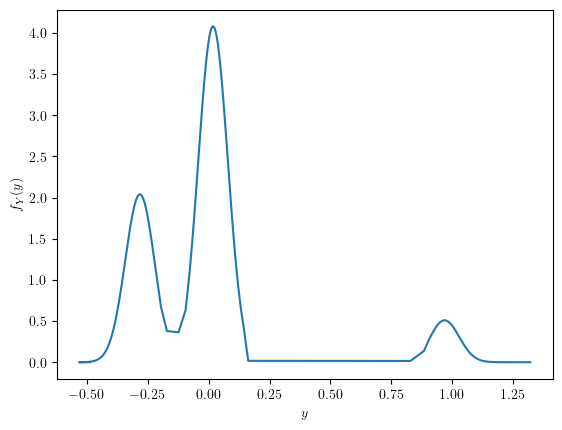

t = 9.005 , int f db = 1.000 



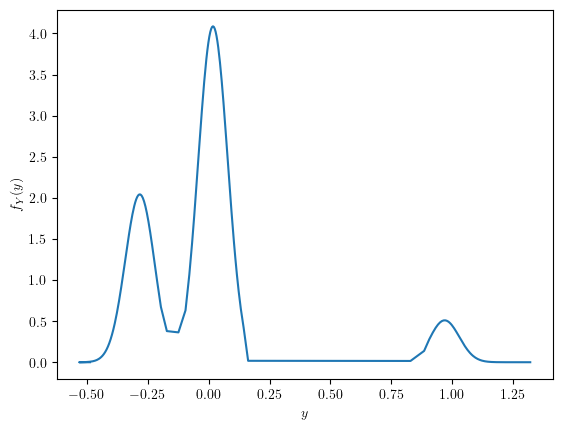

In [49]:
def time_step(X_0, η, D1, L, Nt, T_end, J=lambda t: 1):

    Nη = L.shape[0]
    II = np.eye(Nη)
    T, Δt = np.linspace(0, T_end, Nt, retstep=True)

    LHS = lambda t: II/Δt - J(t)*L/2
    RHS = lambda t: II/Δt + J(t)*L/2

    X = np.zeros((Nt, Nη))
    X[0, :] = X_0
    for n, t in enumerate(T[:-1]):
        X[n+1, :] = np.linalg.solve(LHS(t), RHS(t)@X[n, :] + D1)

        # 0) Plot the system out
        if n%(len(T)//10) == 0:
            D_η = grad(η)
            dY_map_dη = D_η @ X[n, :]
            f_map = g(η)/dY_map_dη
            print('t = %3.3f , int f db = %3.3f \n' %(t,trapz(y=f_map,x=X[n,:]) ))
            fig = plt.figure()
            plt.ylabel('$f_Y(y)$')
            plt.xlabel('$y$')
            plt.plot(X[n, :], f_map)
            plt.show()

    return X, T

# Start from an arbitrary initial condition corresponding to a Gaussian
X_0 = np.linspace(-5, 5, len(η))
Nt = 2*(10**3)
T_end = 10
X, t = time_step(X_0, η, D1, L, Nt, T_end, J=lambda t: 1)

Finally we can animate the time evolution of the previous simulation by using the code below

2025-01-22 14:50:17,401 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-01-22 14:50:17,402 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x400 -pix_fmt rgba -r 10 -i pipe: -vcodec h264 -pix_fmt yuv420p -y Part1_Mapping_SIM.mp4


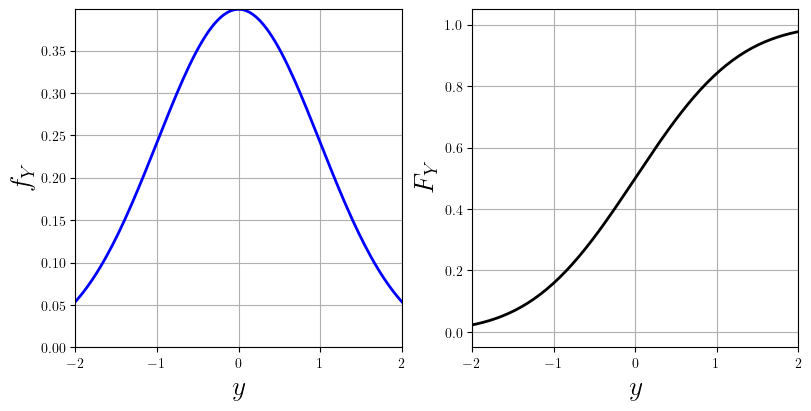

In [51]:
from scipy.integrate import cumulative_trapezoid
from matplotlib.animation import FuncAnimation

def animation(X, η):
    """Generate an animation of the mapping equation. """
    
    # Setup the figure
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout='constrained')

    ax1.set_xlabel(r'$y$', fontsize=20)
    ax1.set_ylabel(r'$f_Y$', fontsize=20)
    ax1.set_xlim([-2, 2])
    #ax2.set_ylim([-.1, .1])
    ax1.grid(True)

    ax2.set_xlabel(r'$y$', fontsize=20)
    ax2.set_ylabel(r'$F_Y$', fontsize=20)
    ax2.set_xlim([-2, 2])
    #ax2.set_ylim([0, 1])
    ax2.grid(True)

    D_η = grad(η)

    def animation_function(i):
        
        dY_map_dη = D_η @ X[i, :]
        f_map = g(η)/dY_map_dη
        F = cumulative_trapezoid(y=f_map, x=X[i, :], initial=0)

        for line in ax1.get_lines():
            line.remove()
        ax1.set_ylim([0,np.max(f_map)])
        line1 = ax1.plot(X[i, :], f_map, 'b', linewidth=2)

        for line in ax2.get_lines():
            line.remove()
        line2 = ax2.plot(X[i, :], F, 'k-', linewidth=2)

        return line1, line2

    anim = FuncAnimation(fig=fig, func=animation_function, frames=np.arange(0, len(X), 10))
    anim.save('Part1_Mapping_SIM.mp4', fps=10)
    
    return None

animation(X,η)